In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
df = pd.read_pickle("../data/df.pickle")

In [3]:
"""Note
データセットの分割
lockdown(2020/4/1~2020/5/31)
2020/6/1~2020/10/31
2020/11/1~2020/11/30
2020/12/1~2020/12/31
2021/1/1~2021/12/31
2022/1/1~2022/12/31
2023/1/1~2023/9/30
"""

# データセットの分割
df_lockdown = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] <= "2020-05-31")]
df_202006_202010 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] <= "2020-10-31")]
df_202011 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] <= "2020-11-30")]
df_202012 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] <= "2020-12-31")]
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2021-12-31")]
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2022-12-31")]
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] <= "2023-09-30")]

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [20]:
def return_nm_string(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='start_station_name')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        # start_station_nameをリスト化
        df_tmp['start_station_id'] = df_tmp['start_station_id'].astype(str)
        df_tmp['end_station_id'] = pd.to_numeric(df_tmp['end_station_id'], errors='coerce')

        station_df = df_tmp[['start_station_id', 'start_station_name']].drop_duplicates()
        station_df = station_df.set_index('start_station_id')

        # node_listにstation_dfの数を追加
        node_list.append(len(station_df))

        # edge_listにdf_tmpの数を追加
        edge_list.append(len(df_tmp))   
        
        current_timestamp = next_timestamp


    # node_listとedge_listで0の値を削除
    
    return node_list, edge_list, timestamp

In [26]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='start_station_name')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        # start_station_nameをリスト化
        df_tmp['start_station_id'] = df_tmp['start_station_id'].astype(float)
        df_tmp['end_station_id'] = pd.to_numeric(df_tmp['end_station_id'], errors='coerce')

        station_df = df_tmp[['start_station_id', 'start_station_name']].drop_duplicates()
        station_df = station_df.set_index('start_station_id')

        # node_listにstation_dfの数を追加
        node_list.append(len(station_df))

        # edge_listにdf_tmpの数を追加
        edge_list.append(len(df_tmp))   
        
        current_timestamp = next_timestamp


    # node_listとedge_listで0の値を削除
    
    return node_list, edge_list, timestamp

In [52]:
# node, edge, timestampの取得
node_lockdown, edge_lockdown, timestamp_lockdown = return_nm(df_lockdown)
node_202006_202010, edge_202006_202010, timestamp_202006_202010 = return_nm(df_202006_202010)
node_202011, edge_202011, timestamp_202011 = return_nm(df_202011)
node_202012, edge_202012, timestamp_202012 = return_nm_string(df_202012)
node_2021, edge_2021, timestamp_2021 = return_nm_string(df_2021)
node_2022, edge_2022, timestamp_2022 = return_nm_string(df_2022)
node_2023, edge_2023, timestamp_2023 = return_nm_string(df_2023)

In [53]:
# activity distribution
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [54]:
"""Note 
各データセットについて、それぞれalphaとbetaを推定する
推定したalphaとbetaは、alpha_listとbeta_listに格納する
"""
alpha_list = []
beta_list = []
df_list = [df_lockdown, df_202006_202010, df_202011, df_202012, df_2021, df_2022, df_2023]
node_list = [node_lockdown, node_202006_202010, node_202011, node_202012, node_2021, node_2022, node_2023]
edge_list = [edge_lockdown, edge_202006_202010, edge_202011, edge_202012, edge_2021, edge_2022, edge_2023]
Np_list = [596, 673, 677, 677, 846, 1416,1416]

In [55]:
for i in range(len(df_list)):
    Np = Np_list[i]
    N = node_list[i]
    M = edge_list[i]
    df = df_list[i]
    # alphaとbetaの推定
    params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
    alpha_list.append(params[0])
    beta_list.append(params[1])

In [56]:
label_list = ["Lockdown", "2020/6/1~2020/10/31", "2020/11/1~2020/11/30", "2020/12/1~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

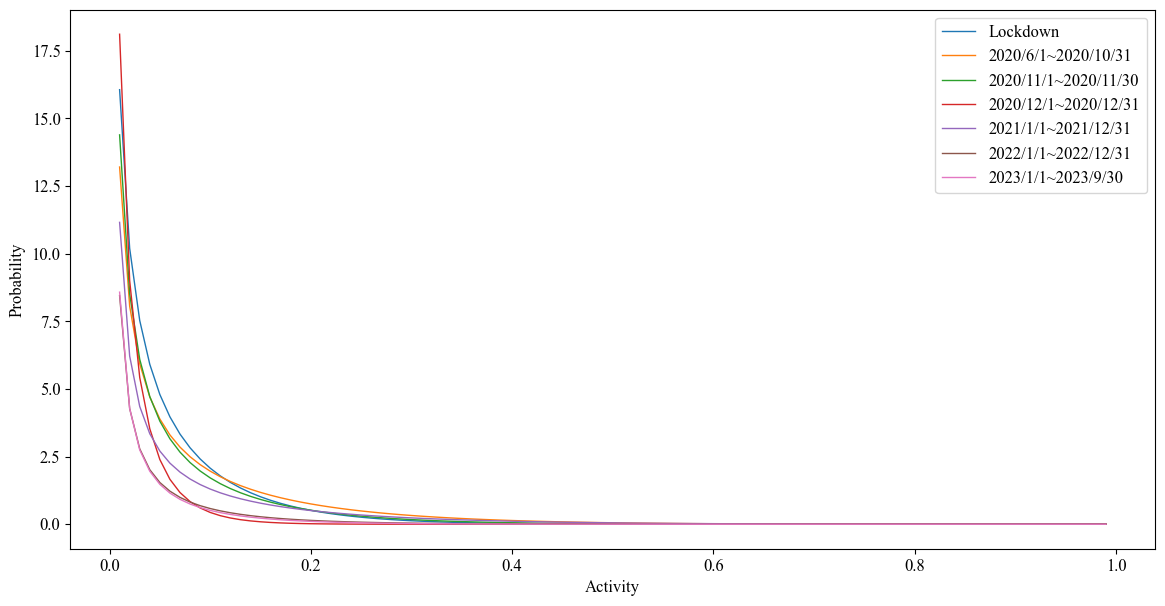

In [57]:
a = np.arange(0, 1, 0.01)

plt.figure(figsize=(14, 7))
for i in range(len(df_list)):
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=label_list[i], linewidth=1)
plt.xlabel("Activity")
plt.ylabel("Probability")
plt.legend()
plt.savefig("../fig/alpha_beta.png")
plt.show()

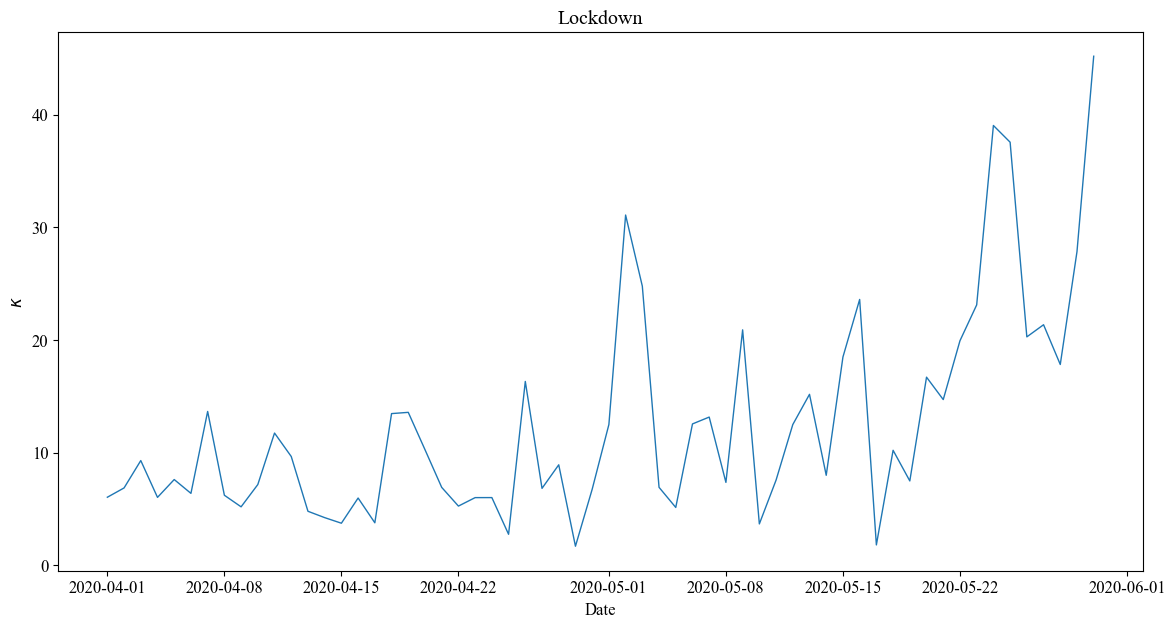

In [58]:
# kappaの計算
kappa_lockdown = []
for i in range(len(edge_lockdown)):
    alpha = alpha_list[0]
    beta = beta_list[0]
    Np = Np_list[0]
    kappa_lockdown.append(kappa(edge_lockdown[i], Np))

plt.figure(figsize=(14, 7))
# フォントの設定
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_lockdown, kappa_lockdown, label=r"$\kappa$", linewidth=1)
plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("Lockdown")
plt.savefig("../fig/kappa_lockdown.png")
plt.show()


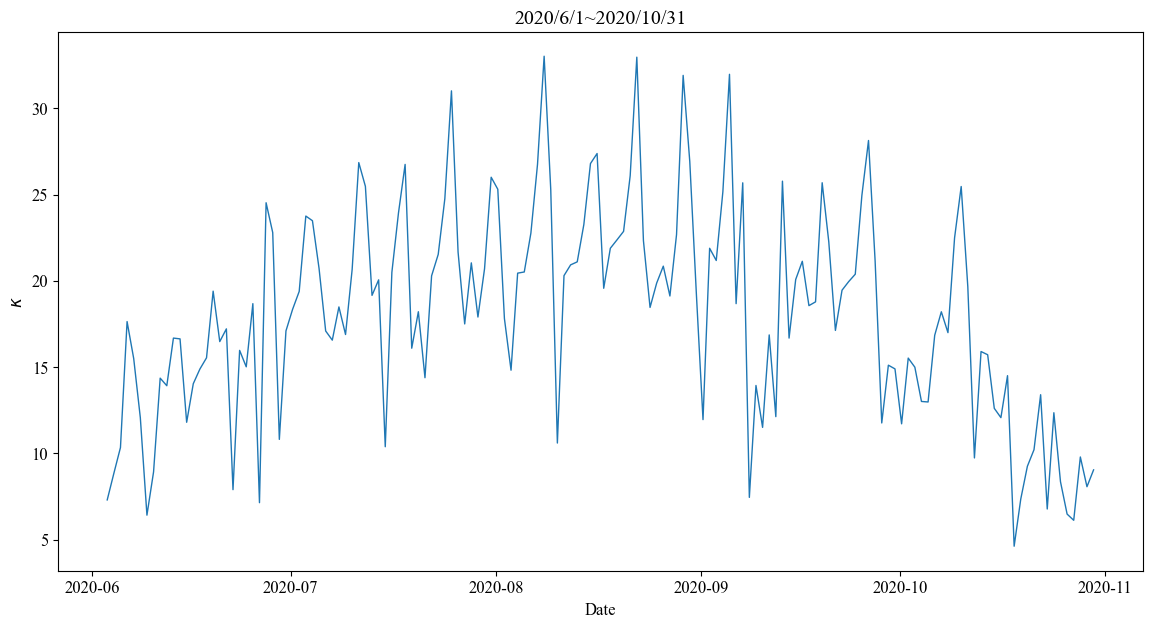

In [59]:
kappa_202006_202010 = []
for i in range(len(edge_202006_202010)):
    alpha = alpha_list[1]
    beta = beta_list[1]
    Np = Np_list[1]
    kappa_202006_202010.append(kappa(edge_202006_202010[i], Np))

plt.figure(figsize=(14, 7))
# フォントの設定
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_202006_202010, kappa_202006_202010, label=r"$\kappa$", linewidth=1)
plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("2020/6/1~2020/10/31")
plt.savefig("../fig/kappa_202006_202010.png")
plt.show()


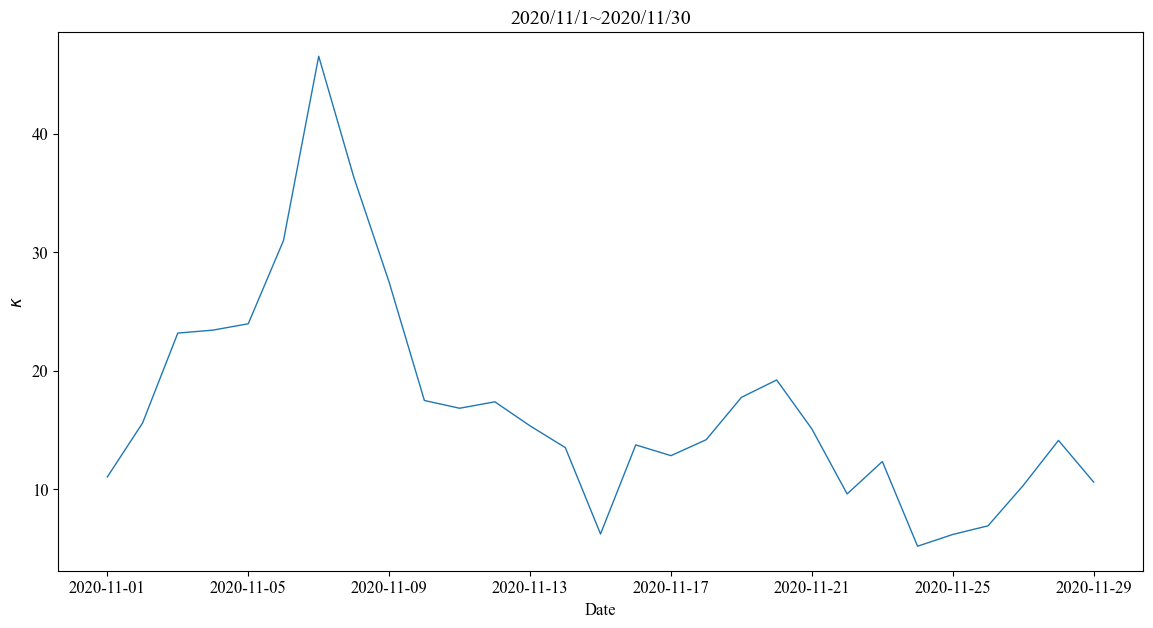

In [60]:
kappa_202011 = []
for i in range(len(edge_202011)):
    alpha = alpha_list[2]
    beta = beta_list[2]
    Np = Np_list[2]
    kappa_202011.append(kappa(edge_202011[i], Np))

plt.figure(figsize=(14, 7))
# フォントの設定
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_202011, kappa_202011, label=r"$\kappa$", linewidth=1)
plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("2020/11/1~2020/11/30")
plt.savefig("../fig/kappa_202011.png")
plt.show()


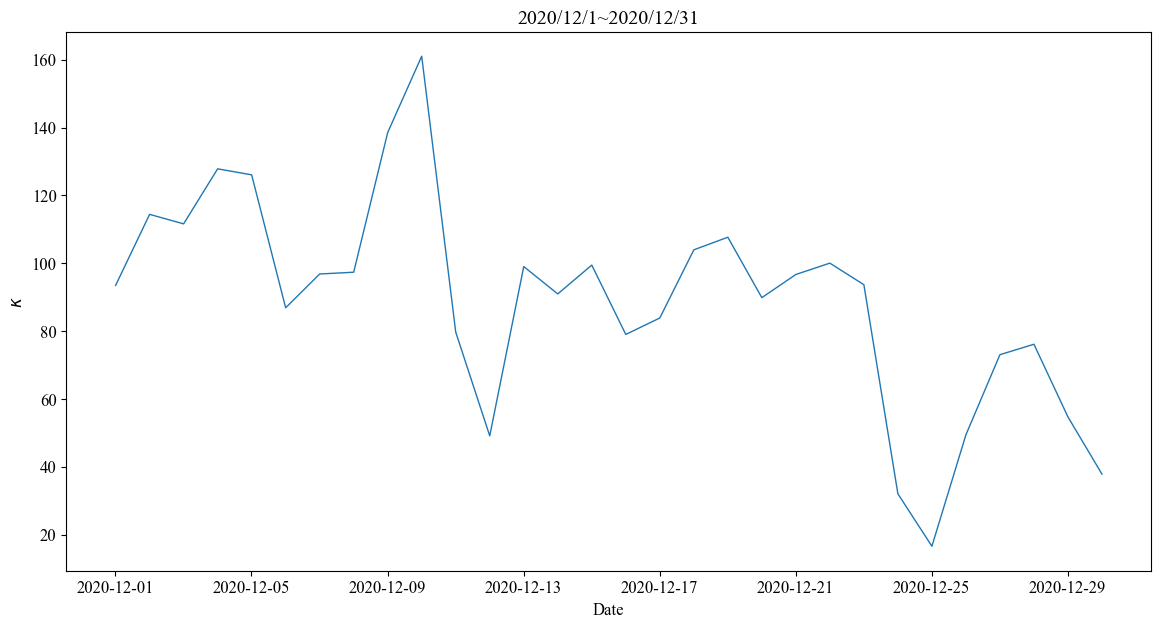

In [61]:
kappa_202012 = []
for i in range(len(edge_202012)):
    alpha = alpha_list[3]
    beta = beta_list[3]
    Np = Np_list[3]
    kappa_202012.append(kappa(edge_202012[i], Np))

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_202012, kappa_202012, label=r"$\kappa$", linewidth=1)
plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("2020/12/1~2020/12/31")
plt.savefig("../fig/kappa_202012.png")
plt.show()

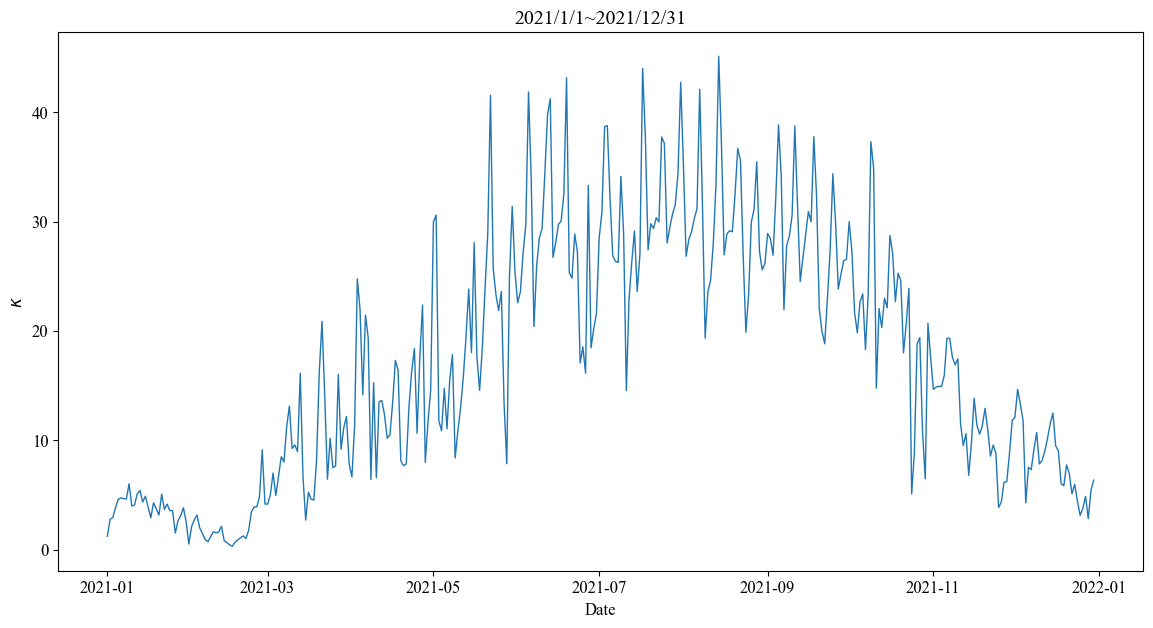

In [62]:
kappa_2021 = []
for i in range(len(edge_2021)):
    alpha = alpha_list[4]
    beta = beta_list[4]
    Np = Np_list[4]
    kappa_2021.append(kappa(edge_2021[i], Np))

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_2021, kappa_2021, label=r"$\kappa$", linewidth=1)
plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("2021/1/1~2021/12/31")
plt.savefig("../fig/kappa_2021.png")
plt.show()

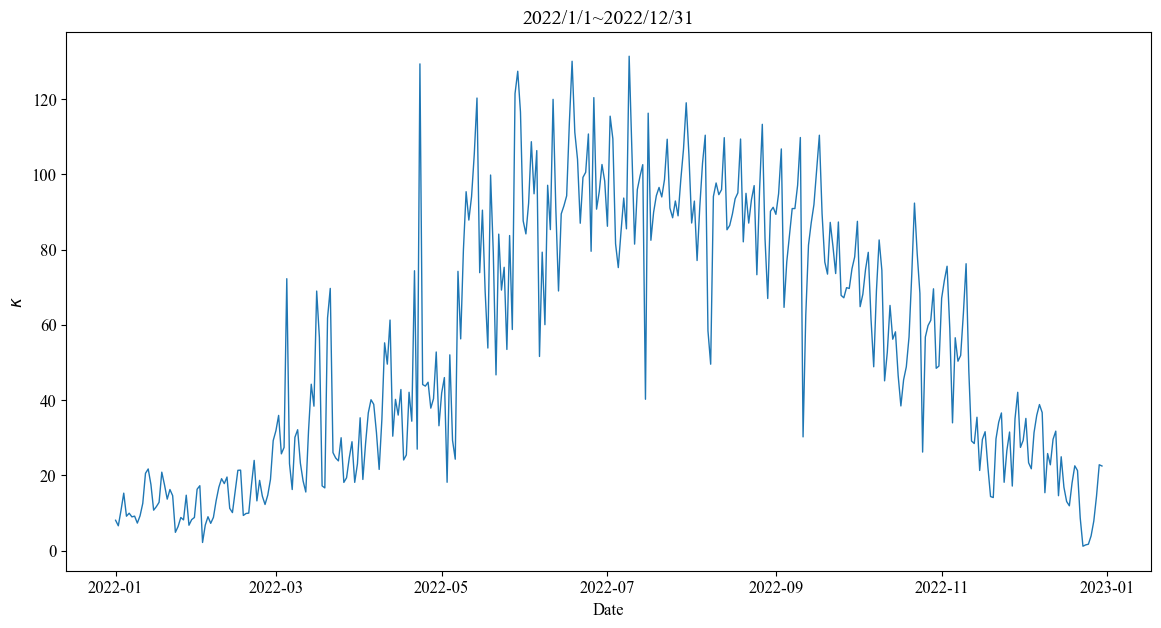

In [63]:
kappa_2022 = []
for i in range(len(edge_2022)):
    alpha = alpha_list[5]
    beta = beta_list[5]
    Np = Np_list[5]
    kappa_2022.append(kappa(edge_2022[i], Np))

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_2022, kappa_2022, label=r"$\kappa$", linewidth=1)
plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("2022/1/1~2022/12/31")
plt.savefig("../fig/kappa_2022.png")
plt.show()

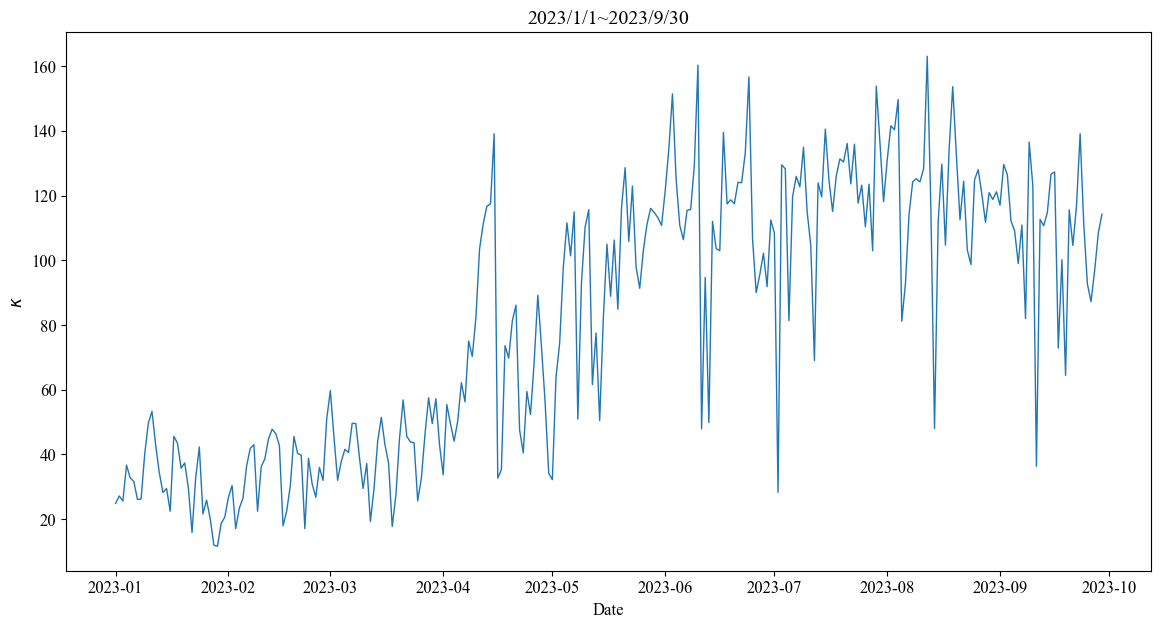

In [64]:
kappa_2023 = []
for i in range(len(edge_2023)):
    alpha = alpha_list[6]
    beta = beta_list[6]
    Np = Np_list[6]
    kappa_2023.append(kappa(edge_2023[i], Np))

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_2023, kappa_2023, label=r"$\kappa$", linewidth=1)
plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("2023/1/1~2023/9/30")
plt.savefig("../fig/kappa_2023.png")
plt.show()


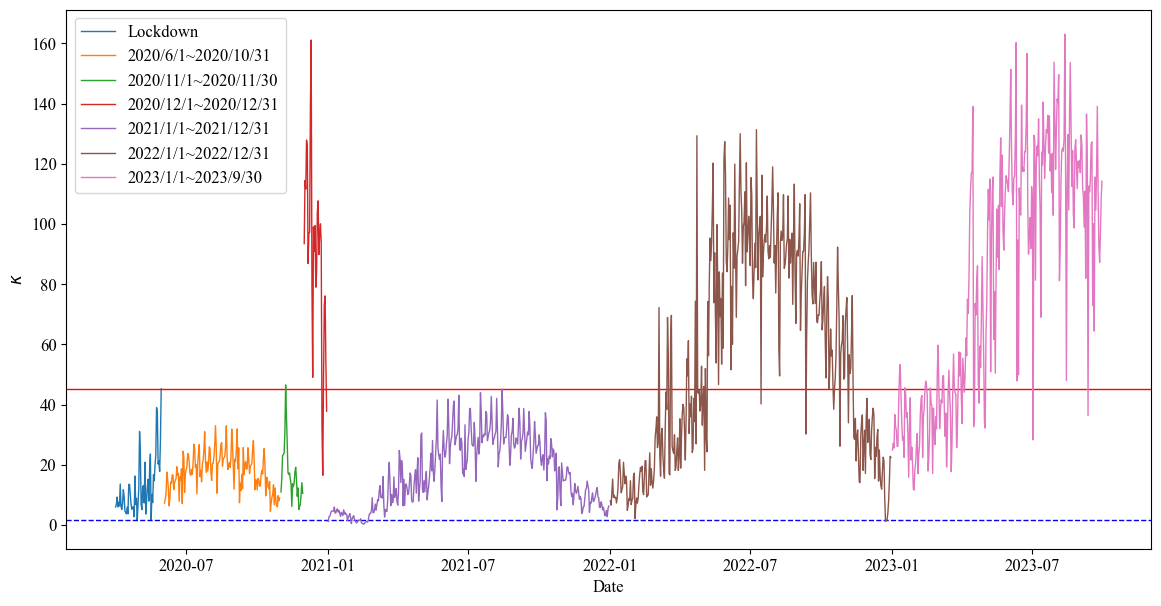

In [71]:
# kappaを重ねてみる
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_lockdown, kappa_lockdown, label="Lockdown", linewidth=1)
# lockdown時の上限と下限のkappaの値に線を引く
plt.axhline(y=np.min(kappa_lockdown), color="blue", linestyle="--", linewidth=1)
plt.axhline(y=np.max(kappa_lockdown), color="red", linestyle="-", linewidth=1)

plt.plot(timestamp_202006_202010, kappa_202006_202010, label="2020/6/1~2020/10/31", linewidth=1)
plt.plot(timestamp_202011, kappa_202011, label="2020/11/1~2020/11/30", linewidth=1)
plt.plot(timestamp_202012, kappa_202012, label="2020/12/1~2020/12/31", linewidth=1)
plt.plot(timestamp_2021, kappa_2021, label="2021/1/1~2021/12/31", linewidth=1)
plt.plot(timestamp_2022, kappa_2022, label="2022/1/1~2022/12/31", linewidth=1)
plt.plot(timestamp_2023, kappa_2023, label="2023/1/1~2023/9/30", linewidth=1)

plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
# plt.yscale("log")
plt.legend()
plt.savefig("../fig/kappa.png")
plt.show()
